<a href="https://colab.research.google.com/github/Naga-SDonepudi/PyTorch_HandsOn/blob/main/5_custom_datasets_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Working with custom datasets using PyTorch

### 1. Setting up device agnostic code
* Before jumping into main step, PyTorch has different existing data loading functions for each problem
  * If the data is vision, look into TorchVision
  * If the data is text, then TorchText followed by TorchAudio and TorchRec for audio and recommendation problems respectively.


In [1]:
import torch
from torch import nn

torch.__version__

'2.9.0+cpu'

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### 2. Gathering the data
* Used Food101 dataset by creating a subset.
* The original dataset has 101 classes / categories with 1000 images in each class
* The custom data i have created will be with 3 classes and 100 images per each class(75 train inages & 25 for testing)
* Always a good idea to start with smaller data, then increasing the scale when required.

In [3]:
import requests
import zipfile
from pathlib import Path

# Data Path
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
  print(f"{image_path} skipping the download, as directory exists")
else:
  print(f"{image_path} creating a directory")
  image_path.mkdir(parents=True, exist_ok=True)

with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  f.write(request.content)

# Unzipping the fil
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping pizza, steak and sushi related data")
  zip_ref.extractall(image_path)

data/pizza_steak_sushi creating a directory
Unzipping pizza, steak and sushi related data


### 3. Data preparation, pre-processing and exploration

In [4]:
import os
def walk_through_directory(dir_path):
  """
  Returns the content of every single directory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images '{dirpath}'.")

In [5]:
walk_through_directory(image_path)

There are 2 directories and 0 images 'data/pizza_steak_sushi'.
There are 3 directories and 0 images 'data/pizza_steak_sushi/test'.
There are 0 directories and 19 images 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images 'data/pizza_steak_sushi/test/pizza'.
There are 3 directories and 0 images 'data/pizza_steak_sushi/train'.
There are 0 directories and 75 images 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images 'data/pizza_steak_sushi/train/pizza'.


In [6]:
### Training an testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### Visualizing the image


Random Image Path: data/pizza_steak_sushi/test/pizza/3475871.jpg
Image Class: pizza
Image Height: 512
Image width: 512


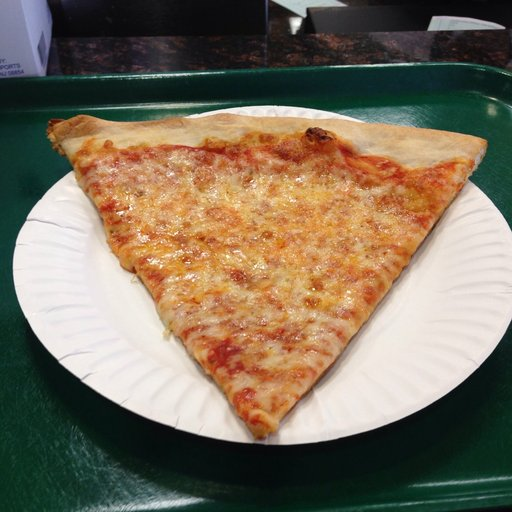

In [7]:
import random
from PIL import Image

random.seed(42)

## Getting the image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

## picking and selecting a random image
random_image = random.choice(image_path_list)

## Image class from path name
image_class = random_image.parent.stem

## Opening and Viewing the image using PIL (Python Image Library)
img = Image.open(random_image)

## Printing metadata
print(f"Random Image Path: {random_image}")
print(f"Image Class: {image_class}")
print(f"Image Height: {img.height}")
print(f"Image width: {img.width}")

img

### Visualizing the image using matplotlib

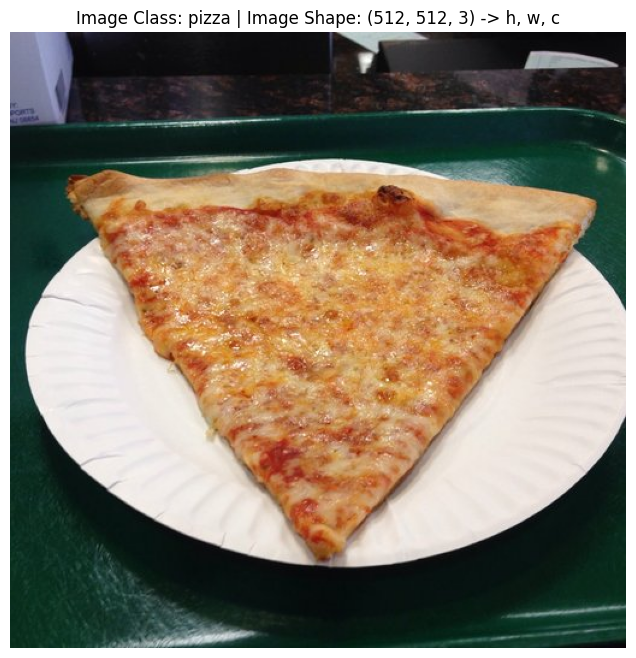

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Image to array
img_to_array = np.asarray(img)

# Plotting the image
plt.figure(figsize=(10, 8))
plt.imshow(img_to_array)
plt.title(f"Image Class: {image_class} | Image Shape: {img_to_array.shape} -> h, w, c")
plt.axis(False)
plt.show()

array([[[137, 137, 163],
        [136, 136, 162],
        [135, 135, 161],
        ...,
        [  7,   7,   9],
        [  7,   7,   9],
        [  7,   7,   9]],

       [[136, 136, 162],
        [136, 136, 162],
        [135, 135, 161],
        ...,
        [  8,   8,  10],
        [  8,   8,  10],
        [  8,   8,  10]],

       [[134, 134, 160],
        [134, 134, 160],
        [135, 135, 163],
        ...,
        [  8,   8,  10],
        [  8,   8,  10],
        [  8,   8,  10]],

       ...,

       [[ 11,  48,  30],
        [  9,  46,  28],
        [  9,  46,  28],
        ...,
        [  7,   7,   7],
        [  7,   7,   7],
        [  7,   7,   7]],

       [[ 13,  50,  32],
        [ 11,  48,  30],
        [ 10,  47,  29],
        ...,
        [ 10,   5,   9],
        [  9,   4,   8],
        [  9,   4,   8]],

       [[ 14,  51,  33],
        [ 12,  49,  31],
        [ 11,  48,  30],
        ...,
        [ 10,   4,   8],
        [  9,   3,   7],
        [  9,   3,   7]]], dtype=uint8)
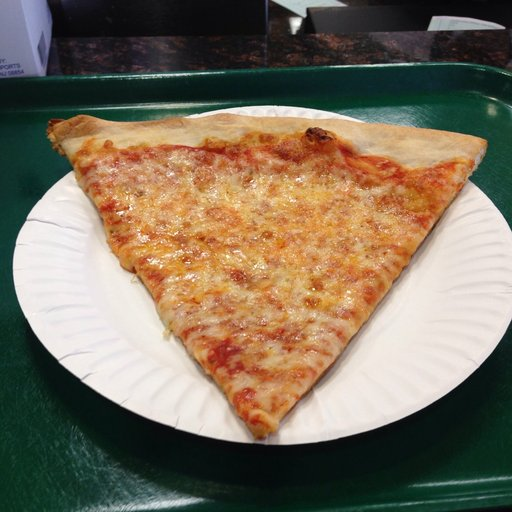

In [9]:
img_to_array

## 4. Turning images to PyTorch tensors and transforming
* Numerical representation of images
* Turning to *torch.utils.data.DataSet* and simultaneously turning dataset into *torch.utils.data.DataLoader*
* torch.utils.data.DataSet to house all the data to tensor format
* torch.utils.data.DataLoader creates an iterable or a batched version of dataset

In [10]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

## Transforming data with torchvision.transforms
* Helps to get the inages ready to be used with a model augmentation

In [11]:
### Transforming data with torchvision.transforms
data_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

In [12]:
data_transform(img)

tensor([[[0.5255, 0.5333, 0.5569,  ..., 0.0353, 0.0353, 0.0392],
         [0.5098, 0.5216, 0.5373,  ..., 0.0431, 0.0431, 0.0471],
         [0.4980, 0.5098, 0.5176,  ..., 0.2118, 0.1098, 0.0627],
         ...,
         [0.0353, 0.0431, 0.0471,  ..., 0.0980, 0.0902, 0.0824],
         [0.0392, 0.0431, 0.0471,  ..., 0.0902, 0.0863, 0.0824],
         [0.0392, 0.0431, 0.0471,  ..., 0.0510, 0.0471, 0.0431]],

        [[0.5294, 0.5373, 0.5686,  ..., 0.0353, 0.0353, 0.0392],
         [0.5216, 0.5294, 0.5529,  ..., 0.0431, 0.0431, 0.0471],
         [0.5137, 0.5216, 0.5373,  ..., 0.2078, 0.1059, 0.0588],
         ...,
         [0.1804, 0.1882, 0.1961,  ..., 0.2627, 0.2549, 0.2471],
         [0.1843, 0.1882, 0.2000,  ..., 0.2471, 0.2431, 0.2314],
         [0.1843, 0.1882, 0.1961,  ..., 0.1294, 0.1098, 0.0980]],

        [[0.6392, 0.6549, 0.7020,  ..., 0.0431, 0.0431, 0.0471],
         [0.6392, 0.6510, 0.6824,  ..., 0.0510, 0.0510, 0.0549],
         [0.6275, 0.6392, 0.6627,  ..., 0.2235, 0.1176, 0.

## 5. Loading Image data using ImageFolder
* ImageFolder is an pre-built datasets function
* Load / Transform image classification data using *torchvision.datasets.ImageFolder*

In [13]:
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, ## Transforming the ip data
                                  target_transform=None) ## Tranforming the label data

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [14]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [15]:
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [16]:
len(train_data)

225

In [17]:
## Getting a single image and label using index on train_data
img, label = train_data[0][0], train_data[0][1]
print(f"Image Tensor: {img}")
print(f"Image Shape: {img.shape}")
print(f"Image Datatype: {img.dtype}")
print(f"Image Label: {label}")
print(class_names[label])
print(f"Label Datatype: {type(label)}")

Image Tensor: tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.01

Original Shape is: torch.Size([3, 64, 64]) -> [c, h, w]
Permuted Image: torch.Size([64, 64, 3]) -> [h, w, c]


Text(0.5, 1.0, 'pizza')

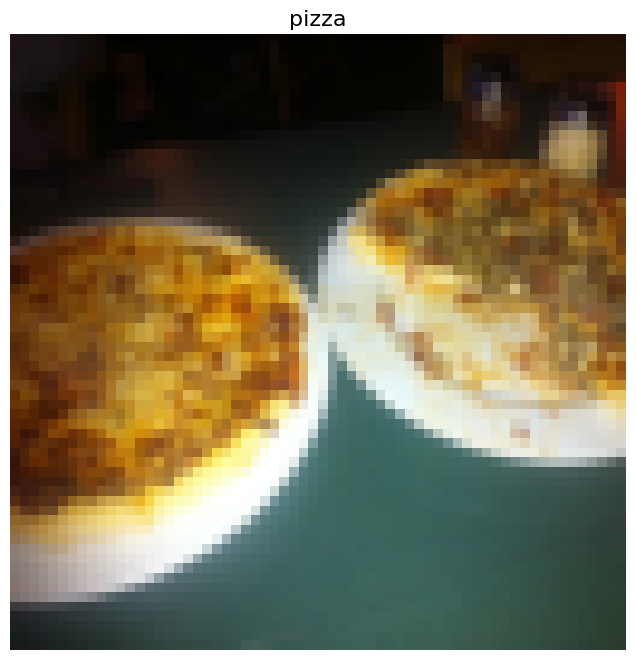

In [18]:
img_permute = img.permute(1,2,0)

print(f"Original Shape is: {img.shape} -> [c, h, w]")
print(f"Permuted Image: {img_permute.shape} -> [h, w, c]")

#Plotting
plt.figure(figsize=(10, 8))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label], fontsize=16)

## Turning loaded images into DataLoaders for batching
* Datsets can be turned into iterable_to_str*
* A batch_size can be ustomized, so that the model can see batch_size images at once (cause without batch size, loading all the images will lead to the hardware running out of memory)

In [19]:
## Turning train and test datasets to dataloaders
from torch.utils.data import DataLoader
BATCH_SIZE = 2
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=os.cpu_count(),
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x78b729ee4b90>,
 <torch.utils.data.dataloader.DataLoader at 0x78b729e049e0>)

In [20]:
len(train_dataloader), len(test_dataloader)

(113, 38)

In [21]:
img, label = next(iter(train_dataloader))

# Batch size is 5
print(f"Image Shape: {img.shape}")
print(f"Label Shape: {label.shape}")

Image Shape: torch.Size([2, 3, 64, 64])
Label Shape: torch.Size([2])


<!-- ## 5.1 Loading Image data with a custom dataset
* Load images and get class names from dataset
* Able to get classes as dictionary from the dataset
* Using a custom dataset often results in writing more code
  -->

## 6. Data Augmentation
* A process of adding the modified copies of already existing data to training data
* Applying various image tarnsformations to train data, incase of image data
* Looking at the same image in a different persepective to increase the diversity of a dataset or image, which results the model to see the unseen image in different angles
* Types like rotate, shift, cropping, replacing, zooming etc
* Used Trivial augmentation ie applying very simple, low-risk data augmentations

In [22]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # 31 is max number on a scale of 0-31 ie how intense the augment should happen
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

train_transform, test_transform

(Compose(
     Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
     TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
     ToTensor()
 ),
 Compose(
     Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
     ToTensor()
 ))

In [23]:
image_path

PosixPath('data/pizza_steak_sushi')

In [24]:
data_path

PosixPath('data')

In [25]:
## Getting all of the image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:5]

[PosixPath('data/pizza_steak_sushi/test/steak/1016217.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/894825.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/296375.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/27415.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/2117351.jpg')]

# Model Buidling (without data augmentation)
* Using the CNN TinyVGG architecture

## 1. Loading Data

In [26]:
## Creating a transform to load the data, images and turning to tensors
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [27]:
## Using ImageFolder
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform = data_transform)

test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=data_transform)

## Datasets to dataloaders
import os
from torch.utils.data import DataLoader

## Batzh size
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

## Creating data laoder
train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False)

## 2. Bulding the model

In [28]:
class TinyVGG(nn.Module):
  def __init__(self, input_shape: int,
               hidden_units: int,
               output_shape: int) -> None:
    super().__init__()

    # Convolution block 1
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )

    # Convolution block 2
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*16*16,
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    #print(x.shape)
    x = self.conv_block_2(x)
    #print(x.shape)
    x = self.classifier(x)
    #print(x.shape)
    return x

In [29]:
torch.manual_seed(42)
model_1 = TinyVGG(input_shape=3, # Color channels
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

### Summary of model using torchinfo
* To get an idea about the shapes going throgh the model


In [30]:
!pip install torchinfo

In [31]:
import torchinfo

In [32]:
from torchinfo import summary
summary(model_1, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

## 2.1 Training and testing steps

In [33]:
## Creating training steps by starting off with defining a function
def train_mode(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):

  model.train()

  # Setting up evaluation metrics
  train_loss, train_acc = 0,0

  # Loop through dataloader databatch
  for batch, (X,y) in enumerate(dataloader):

    # Sending data to target device
    X,y = X.to(device), y.to(device)

    ## 1. Performing forward pass
    y_pred = model(X)

    ## 2. Loss calculation and accumulate to train_loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    ## 3. Optimizer zero grad
    optimizer.zero_grad()

    ## 4. Backward loss propagarion
    loss.backward()

    ## 5. Optimization
    optimizer.step()

    ## Calculating accuracy
    y_pred_class = y_pred.argmax(dim=1)
    train_acc += (y_pred_class==y).sum().item() / len(y_pred)

  ## Adjusting metrics for avg loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

In [34]:
## Testing loop
def test_mode(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):

  # Eval mode
  model.eval()

  # Test loss and tess accuracy metrics values
  test_loss, test_acc = 0,0

  # Inference mode
  with torch.inference_mode():

    ## Loop through dl
    for batch, (X, y) in enumerate(dataloader):

      # Data to target device
      X, y = X.to(device), y.to(device)

      ## Forward Pass
      test_pred = model(X)

      ## Loss
      loss = loss_fn(test_pred, y)
      test_loss += loss.item()

      # Accuracy
      test_pred_labels = test_pred.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item() / len(test_pred_labels))

  ## Adjusting metrics
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

In [35]:
# Combining the training and testing steps
from tqdm.auto import tqdm

## Creating a function for train
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module=nn.CrossEntropyLoss(),
          epochs: int=5,
          device=device):

  ## Creating an empty dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Looping through the train and tetsing steps
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_mode(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)

    test_loss, test_acc = test_mode(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)

    ## Printing out whats goin on
    print(f"Epoch: {epoch} | Training Loss: {train_loss:.4f} | Training Accuracy: {train_acc:.2f}% | Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.2f}%")

    ## Results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results

In [36]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Epochs
NUM_EPOCHS = 6

# Recreating Instantiation
model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

# Loss Function an optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.001)

## Timer
from timeit import default_timer as timer
start_time = timer()

# Training step
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

## Timer end
end_time = timer()
print(f"Training Time: {end_time-start_time: .2f} seconds")

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 0 | Training Loss: 1.1078 | Training Accuracy: 0.26% | Test Loss: 1.1362 | Test Accuracy: 0.26%
Epoch: 1 | Training Loss: 1.0846 | Training Accuracy: 0.43% | Test Loss: 1.1622 | Test Accuracy: 0.20%
Epoch: 2 | Training Loss: 1.1153 | Training Accuracy: 0.29% | Test Loss: 1.1695 | Test Accuracy: 0.20%
Epoch: 3 | Training Loss: 1.0990 | Training Accuracy: 0.29% | Test Loss: 1.1343 | Test Accuracy: 0.20%
Epoch: 4 | Training Loss: 1.0990 | Training Accuracy: 0.29% | Test Loss: 1.1434 | Test Accuracy: 0.20%
Epoch: 5 | Training Loss: 1.0964 | Training Accuracy: 0.31% | Test Loss: 1.1483 | Test Accuracy: 0.26%
Training Time:  23.24 seconds


In [37]:
model_1_results

{'train_loss': [1.1078356951475143,
  1.0846453607082367,
  1.1152610331773758,
  1.0990152657032013,
  1.0989657938480377,
  1.0964482873678207],
 'train_acc': [0.2578125,
  0.42578125,
  0.29296875,
  0.2890625,
  0.29296875,
  0.3125],
 'test_loss': [1.1362075010935466,
  1.1621707677841187,
  1.169488827387492,
  1.1343015034993489,
  1.14342466990153,
  1.148282527923584],
 'test_acc': [0.2604166666666667,
  0.19791666666666666,
  0.19791666666666666,
  0.19791666666666666,
  0.19791666666666666,
  0.2604166666666667]}

# Model building with data augmentation
* Data Augmentation in one way of dealing with model's overfitting.


## 1. Creating a transform for loading the data

In [38]:
from torchvision import transforms
train_trivial_transform = transforms.Compose([transforms.Resize(size=(64, 64)),
                                             transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                             transforms.ToTensor()])


# No data augmentation on test dataset, cause models not gonna learn any patterns from test set unlike train
test_trivial_transform = transforms.Compose([transforms.Resize(size=(64, 64)),
                                             transforms.ToTensor()])

## 2. Creating Datasets and DataLoaders for train and test
* Turning images to datasets
* Turning datasets to dataloaders

In [39]:
# Img folders to datasets
from torchvision import datasets
train_data_aug = datasets.ImageFolder(root=train_dir,
                                      transform=train_trivial_transform)

test_data_aug = datasets.ImageFolder(root=test_dir,
                                     transform=test_trivial_transform)

In [40]:
# Datasets to dataloaders
import os
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)

train_dataloader_aug = DataLoader(dataset=train_data_aug,
                                  batch_size=BATCH_SIZE,
                                  num_workers=NUM_WORKERS,
                                  shuffle=True)

test_dataloader_aug = DataLoader(dataset=test_data_aug,
                                 batch_size=BATCH_SIZE,
                                 num_workers=NUM_WORKERS,
                                 shuffle=False)

## 3. Building a model

In [41]:
class TinyVGG(nn.Module):
  def __init__(self, input_shape: int,
               hidden_units: int,
               output_shape: int) -> None:
    super().__init__()

    # Convolution block 1
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )

    # Convolution block 2
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*16*16,
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    #print(x.shape)
    x = self.conv_block_2(x)
    #print(x.shape)
    x = self.classifier(x)
    #print(x.shape)
    return x

In [42]:
torch.manual_seed(42)

model_2 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape = len(train_data_aug.classes)).to(device)
model_2

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [43]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Setting number of epochs
NUM_EPOCHS = 6

#Loss Function (Criterion) and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_2.parameters(),
                             lr=0.001)

# Timer setup
from timeit import default_timer as timer
start_time = timer()

# Train Model 1
model_2_results = train(model=model_2,
                        train_dataloader=train_dataloader_aug,
                        test_dataloader=test_dataloader_aug,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        device=device)

end_time = timer()
print(f"Training Time of Model_2: {end_time-start_time:.2f} seconds")

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 0 | Training Loss: 1.1076 | Training Accuracy: 0.25% | Test Loss: 1.1062 | Test Accuracy: 0.26%
Epoch: 1 | Training Loss: 1.0791 | Training Accuracy: 0.43% | Test Loss: 1.1387 | Test Accuracy: 0.26%
Epoch: 2 | Training Loss: 1.0810 | Training Accuracy: 0.43% | Test Loss: 1.1696 | Test Accuracy: 0.26%
Epoch: 3 | Training Loss: 1.1292 | Training Accuracy: 0.30% | Test Loss: 1.1625 | Test Accuracy: 0.26%
Epoch: 4 | Training Loss: 1.0899 | Training Accuracy: 0.43% | Test Loss: 1.1482 | Test Accuracy: 0.26%
Epoch: 5 | Training Loss: 1.0953 | Training Accuracy: 0.30% | Test Loss: 1.1437 | Test Accuracy: 0.26%
Training Time of Model_2: 18.91 seconds


In [44]:
model_2_results

{'train_loss': [1.1075671762228012,
  1.0790971890091896,
  1.0809668004512787,
  1.1292142122983932,
  1.0899091511964798,
  1.0953071564435959],
 'train_acc': [0.25, 0.42578125, 0.42578125, 0.3046875, 0.42578125, 0.3046875],
 'test_loss': [1.10621972878774,
  1.1387190222740173,
  1.169558008511861,
  1.1625247200330098,
  1.148215929667155,
  1.1437174479166667],
 'test_acc': [0.2604166666666667,
  0.2604166666666667,
  0.2604166666666667,
  0.2604166666666667,
  0.2604166666666667,
  0.2604166666666667]}

### Comparing the results of models

In [45]:
import pandas as pd
model_1_df = pd.DataFrame(model_1_results)
model_2_df = pd.DataFrame(model_2_results)

model_2_df

,train_loss,train_acc,test_loss,test_acc
0,1.107567,0.250000,1.106220,0.260417
1,1.079097,0.425781,1.138719,0.260417
2,1.080967,0.425781,1.169558,0.260417
3,1.129214,0.304688,1.162525,0.260417
4,1.089909,0.425781,1.148216,0.260417
5,1.095307,0.304688,1.143717,0.260417


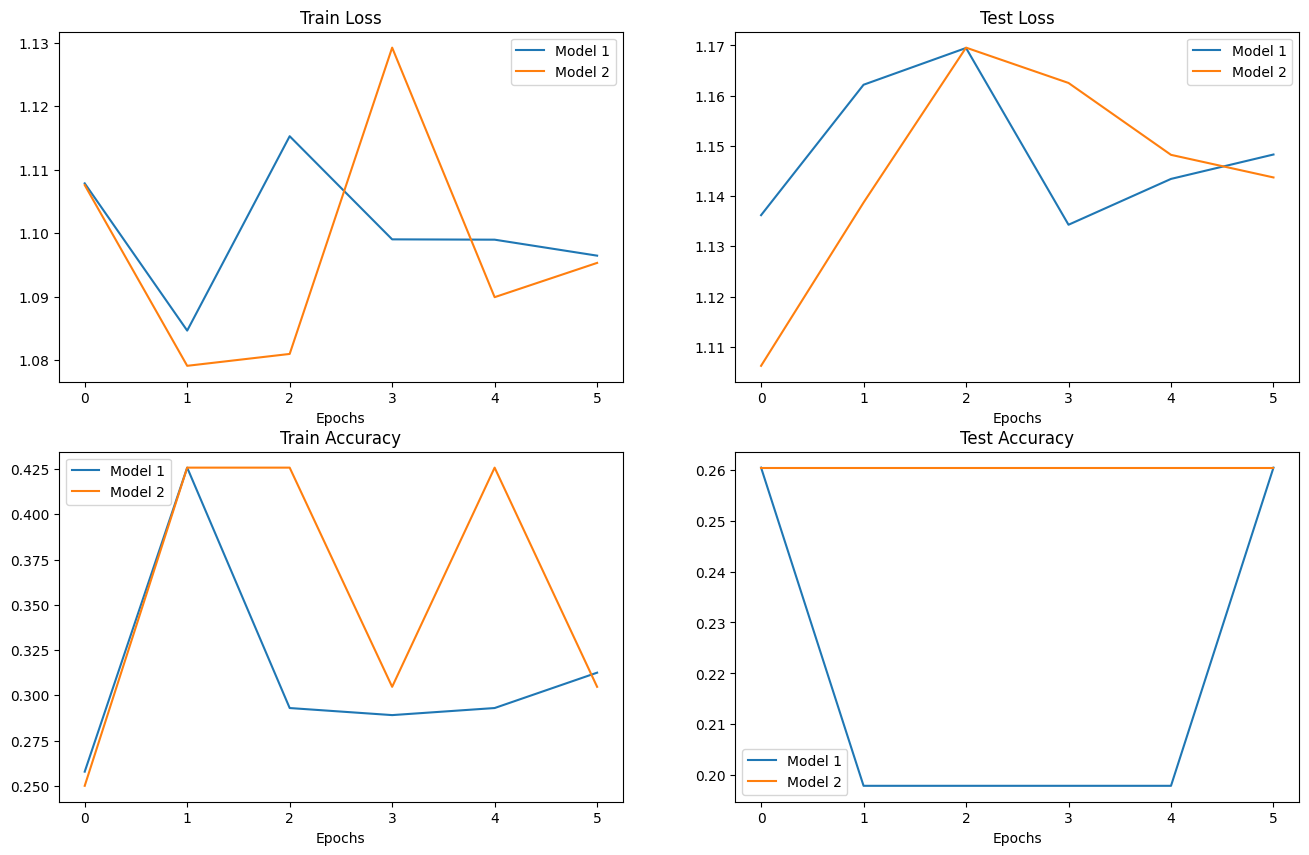

In [46]:
plt.figure(figsize=(16, 10))

epochs = range(len(model_1_df))

# Train Loss plot
plt.subplot(2, 2, 1)
plt.plot(epochs, model_1_df["train_loss"], label = "Model 1")
plt.plot(epochs, model_2_df["train_loss"], label= "Model 2")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Test loss plot
plt.subplot(2, 2, 2)
plt.plot(epochs, model_1_df["test_loss"], label = "Model 1")
plt.plot(epochs, model_2_df["test_loss"], label= "Model 2")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Train accuracy plot
plt.subplot(2, 2, 3)
plt.plot(epochs, model_1_df["train_acc"], label = "Model 1")
plt.plot(epochs, model_2_df["train_acc"], label= "Model 2")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Test accuracy plot
plt.subplot(2, 2, 4)
plt.plot(epochs, model_1_df["test_acc"], label = "Model 1")
plt.plot(epochs, model_2_df["test_acc"], label= "Model 2")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend()

## Predictions on a custom image

In [47]:
import requests

custom_img_path = data_path / "pizz.jpg"

if not custom_img_path.is_file():
  with open(custom_img_path, "wb") as f:
    request = requests.get("https://raw.githubusercontent.com/Naga-SDonepudi/PyTorch_HandsOn/refs/heads/main/pizz.jpg.jpg")
    print(f"Downloading and saving the {custom_img_path}")
    f.write(request.content)
else:
  print(f"{custom_img_path} is already there")


### Custom image to tensor form

In [48]:
import torchvision

# Using read_image function from torchvision
custom_image = torchvision.io.read_image(custom_img_path)
custom_image

tensor([[[221, 222, 219,  ...,  23, 144, 202],
         [211, 223, 222,  ...,  62, 146, 181],
         [220, 226, 222,  ..., 131, 139, 141],
         ...,
         [177, 186, 193,  ..., 195, 201, 200],
         [186, 184, 189,  ..., 206, 208, 198],
         [185, 190, 197,  ..., 209, 198, 172]],

        [[225, 226, 220,  ...,  31, 149, 207],
         [215, 227, 223,  ...,  67, 151, 186],
         [224, 230, 226,  ..., 135, 143, 145],
         ...,
         [178, 187, 194,  ..., 195, 201, 200],
         [185, 183, 188,  ..., 206, 208, 198],
         [184, 189, 196,  ..., 209, 198, 172]],

        [[226, 227, 222,  ...,  34, 153, 210],
         [216, 228, 225,  ...,  71, 154, 189],
         [225, 231, 227,  ..., 138, 146, 146],
         ...,
         [182, 191, 198,  ..., 195, 203, 202],
         [190, 188, 193,  ..., 204, 208, 198],
         [189, 194, 201,  ..., 207, 198, 172]]], dtype=torch.uint8)

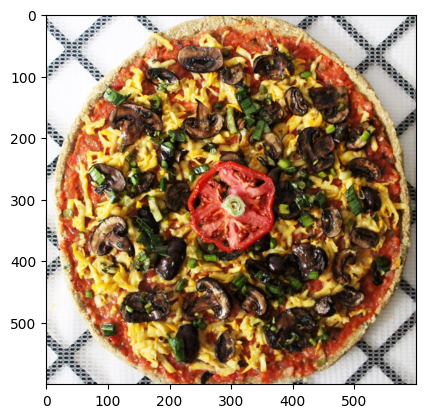

In [49]:
plt.imshow(custom_image.permute(1, 2, 0))
plt.show()

In [50]:
print(f"Custom Image Shape: {custom_image.shape}")
print(f"Custom Image dtype: {custom_image.dtype}")

Custom Image Shape: torch.Size([3, 600, 600])
Custom Image dtype: torch.uint8


In [51]:
## Converting img tensor to float 32 and dividing by 255 to make tensor values bet 0 and 1
custom_image = torchvision.io.read_image(custom_img_path).type(torch.float32) / 255
custom_image

tensor([[[0.8667, 0.8706, 0.8588,  ..., 0.0902, 0.5647, 0.7922],
         [0.8275, 0.8745, 0.8706,  ..., 0.2431, 0.5725, 0.7098],
         [0.8627, 0.8863, 0.8706,  ..., 0.5137, 0.5451, 0.5529],
         ...,
         [0.6941, 0.7294, 0.7569,  ..., 0.7647, 0.7882, 0.7843],
         [0.7294, 0.7216, 0.7412,  ..., 0.8078, 0.8157, 0.7765],
         [0.7255, 0.7451, 0.7725,  ..., 0.8196, 0.7765, 0.6745]],

        [[0.8824, 0.8863, 0.8627,  ..., 0.1216, 0.5843, 0.8118],
         [0.8431, 0.8902, 0.8745,  ..., 0.2627, 0.5922, 0.7294],
         [0.8784, 0.9020, 0.8863,  ..., 0.5294, 0.5608, 0.5686],
         ...,
         [0.6980, 0.7333, 0.7608,  ..., 0.7647, 0.7882, 0.7843],
         [0.7255, 0.7176, 0.7373,  ..., 0.8078, 0.8157, 0.7765],
         [0.7216, 0.7412, 0.7686,  ..., 0.8196, 0.7765, 0.6745]],

        [[0.8863, 0.8902, 0.8706,  ..., 0.1333, 0.6000, 0.8235],
         [0.8471, 0.8941, 0.8824,  ..., 0.2784, 0.6039, 0.7412],
         [0.8824, 0.9059, 0.8902,  ..., 0.5412, 0.5725, 0.

### Using a transform pipeline for resizing

In [52]:
from torchvision import transforms
custom_transform_image = transforms.Compose([transforms.Resize(size=(64, 64))
                                             ])

custom_transformed_image = custom_transform_image(custom_image)
print(f"Original Shape before transform: {custom_image.shape}")
print(f"Transformed image shape: {custom_transformed_image.shape}")

Original Shape before transform: torch.Size([3, 600, 600])
Transformed image shape: torch.Size([3, 64, 64])


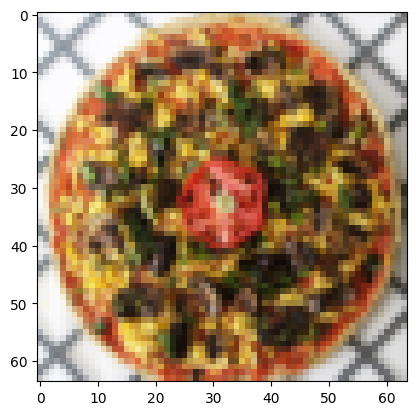

In [53]:
plt.imshow(custom_transformed_image.permute(1,2,0))

In [54]:
## Predictions
model_2.eval()
with torch.inference_mode():
  custom_image_pred = model_2(custom_transformed_image.unsqueeze(0).to(device))
custom_image_pred

tensor([[ 0.0811,  0.0487, -0.1288]])

### Logits to prediction probabilities then pred labels

In [55]:
custom_image_pred_prob = torch.softmax(custom_image_pred, dim=1)
custom_image_pred_classes = torch.argmax(custom_image_pred_prob, dim=1)

In [56]:
custom_image_pred_classes

tensor([0])

In [57]:
class_names[custom_image_pred_classes]

'pizza'

### Bulding a function

In [58]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str])

SyntaxError: expected '(' (ipython-input-1100973455.py, line 1)